# Step-by-Step: Gradient Boosting (GBM) — Hồi quy (MSE)


## 1. Import Libraries

In [ ]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from sklearn.metrics import mean_squared_error, log_loss
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor, plot_tree

## 2. Dataset & Helpers


In [ ]:
xs = np.array([1, 2, 3, 4], dtype=float)
y_reg = np.array([2, 3, 5, 6], dtype=float)
y_bin = np.array([0, 0, 1, 1], dtype=float)

thresholds = [1.5, 2.5, 3.5]

def r2(x):
    return float(f"{x:.2f}")

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

## 3. GBM Regression (MSE)

In [ ]:
def gbm_regression_two_rounds(xs, y_reg, thresholds):
    print("=== (A) HỒI QUY (MSE) — 2 vòng ===")
    # Bước 1 — Khởi tạo
    F0 = float(y_reg.mean())
    print(f"Bước 1 — Khởi tạo: F0 = mean(y) = {y_reg.sum():.0f}/{len(y_reg)} = {r2(F0)}")

    # Vòng 1
    print("\nBước 2 — Vòng 1:")
    r1 = y_reg - F0
    print(f"Residual r1 = {[f'{v:+.2f}' for v in r1]}")

    details = []
    for t in thresholds:
        left  = r1[xs < t]
        right = r1[xs >= t]
        lm = left.mean() if len(left) else 0.0
        rm = right.mean() if len(right) else 0.0
        ssel = float(((left - lm)**2).sum())
        sser = float(((right - rm)**2).sum())
        total = ssel + sser
        details.append((t, lm, rm, ssel, sser, total, left, right))

    # tie-break: chọn ngưỡng lớn hơn khi tổng SSE bằng nhau
    t1, lm1, rm1, ssel1, sser1, total1, left1, right1 = sorted(details, key=lambda z: (z[5], -z[0]))[0]
    for (t, lm, rm, ssel, sser, total, left, right) in details:
        print(f"  Ngưỡng {t}:")
        print(f"    Trái {list(map(float,left))} -> mean={r2(lm)}, SSE_trái={r2(ssel)}")
        print(f"    Phải {list(map(float,right))} -> mean={r2(rm)}, SSE_phải={r2(sser)}")
        print(f"    Tổng SSE = {r2(total)}")
    print(f"=> Chọn ngưỡng vòng 1: x < {t1} (Tổng SSE = {r2(total1)})")

    g1L = float(left1.mean())
    g1R = float(right1.mean())
    print(f"gamma_left = mean({[r2(v) for v in left1]}) = {r2(g1L)}")
    print(f"gamma_right = mean({[r2(v) for v in right1]}) = {r2(g1R)}")

    def stump_value_round1(x):
        return g1L if x < t1 else g1R

    F1 = np.array([F0 + stump_value_round1(x) for x in xs])
    print(f"F1(x_i) = {[r2(v) for v in F1]}")
    mse1_manual = float(((y_reg - F1)**2).mean())
    mse1_sklearn = mean_squared_error(y_reg, F1)
    print(f"MSE_1 manual = {r2(mse1_manual)}, sklearn = {r2(mse1_sklearn)}")

    # Cross-check bằng DecisionTreeRegressor (fit residuals)
    tree1 = DecisionTreeRegressor(max_depth=1)
    tree1.fit(xs.reshape(-1,1), r1)
    print("Check stump sklearn (vòng 1):")
    print("  thresholds:", tree1.tree_.threshold)
    print("  values:", tree1.tree_.value.ravel())

    # Vòng 2
    print("\nBước 3 — Vòng 2:")
    r2v = y_reg - F1
    print(f"Residual r2 = {[f'{v:+.2f}' for v in r2v]}")

    details2 = []
    for t in thresholds:
        left  = r2v[xs < t]
        right = r2v[xs >= t]
        lm = left.mean() if len(left) else 0.0
        rm = right.mean() if len(right) else 0.0
        ssel = float(((left - lm)**2).sum())
        sser = float(((right - rm)**2).sum())
        total = ssel + sser
        details2.append((t, lm, rm, ssel, sser, total, left, right))

    t2, lm2, rm2, ssel2, sser2, total2, left2, right2 = sorted(details2, key=lambda z: (z[5], -z[0]))[0]
    for (t, lm, rm, ssel, sser, total, left, right) in details2:
        print(f"  Ngưỡng {t}:")
        print(f"    Trái {list(map(float,left))} -> mean={r2(lm)}, SSE_trái={r2(ssel)}")
        print(f"    Phải {list(map(float,right))} -> mean={r2(rm)}, SSE_phải={r2(sser)}")
        print(f"    Tổng SSE = {r2(total)}")
    print(f"=> Chọn ngưỡng vòng 2: x < {t2} (Tổng SSE = {r2(total2)})")

    g2L = float(left2.mean())
    g2R = float(right2.mean())
    print(f"gamma_left_2 = mean({[r2(v) for v in left2]}) = {r2(g2L)}")
    print(f"gamma_right_2 = mean({[r2(v) for v in right2]}) = {r2(g2R)}")

    def stump_value_round2(x):
        return g2L if x < t2 else g2R

    F2 = np.array([F1[i] + stump_value_round2(xs[i]) for i in range(len(xs))])
    print(f"F2(x_i) = {[r2(v) for v in F2]}")
    mse2_manual = float(((y_reg - F2)**2).mean())
    mse2_sklearn = mean_squared_error(y_reg, F2)
    print(f"MSE_2 manual = {r2(mse2_manual)}, sklearn = {r2(mse2_sklearn)}")

    # Cross-check bằng DecisionTreeRegressor (fit residuals vòng 2)
    tree2 = DecisionTreeRegressor(max_depth=1)
    tree2.fit(xs.reshape(-1,1), r2v)
    print("Check stump sklearn (vòng 2):")
    print("  thresholds:", tree2.tree_.threshold)
    print("  values:", tree2.tree_.value.ravel())

    return {
        'F0':F0, 'F1':F1, 'F2':F2,
        't1':t1, 't2':t2,
        'g1L':g1L, 'g1R':g1R, 'g2L':g2L, 'g2R':g2R,
        'mse1':mse1_manual, 'mse2':mse2_manual
    }

reg = gbm_regression_two_rounds(xs, y_reg, thresholds)

=== (A) HỒI QUY (MSE) — 2 vòng ===
Bước 1 — Khởi tạo: F0 = mean(y) = 16/4 = 4.0

Bước 2 — Vòng 1:
Residual r1 = ['-2.00', '-1.00', '+1.00', '+2.00']
  Ngưỡng 1.5:
    Trái [-2.0] -> mean=-2.0, SSE_trái=0.0
    Phải [-1.0, 1.0, 2.0] -> mean=0.67, SSE_phải=4.67
    Tổng SSE = 4.67
  Ngưỡng 2.5:
    Trái [-2.0, -1.0] -> mean=-1.5, SSE_trái=0.5
    Phải [1.0, 2.0] -> mean=1.5, SSE_phải=0.5
    Tổng SSE = 1.0
  Ngưỡng 3.5:
    Trái [-2.0, -1.0, 1.0] -> mean=-0.67, SSE_trái=4.67
    Phải [2.0] -> mean=2.0, SSE_phải=0.0
    Tổng SSE = 4.67
=> Chọn ngưỡng vòng 1: x < 2.5 (Tổng SSE = 1.0)
gamma_left = mean([-2.0, -1.0]) = -1.5
gamma_right = mean([1.0, 2.0]) = 1.5
F1(x_i) = [2.5, 2.5, 5.5, 5.5]
MSE_1 manual = 0.25, sklearn = 0.25
Check stump sklearn (vòng 1):
  thresholds: [ 2.5 -2.  -2. ]
  values: [ 0.  -1.5  1.5]

Bước 3 — Vòng 2:
Residual r2 = ['-0.50', '+0.50', '-0.50', '+0.50']
  Ngưỡng 1.5:
    Trái [-0.5] -> mean=-0.5, SSE_trái=0.0
    Phải [0.5, -0.5, 0.5] -> mean=0.17, SSE_phải=0.67
  

## 4. Visualization

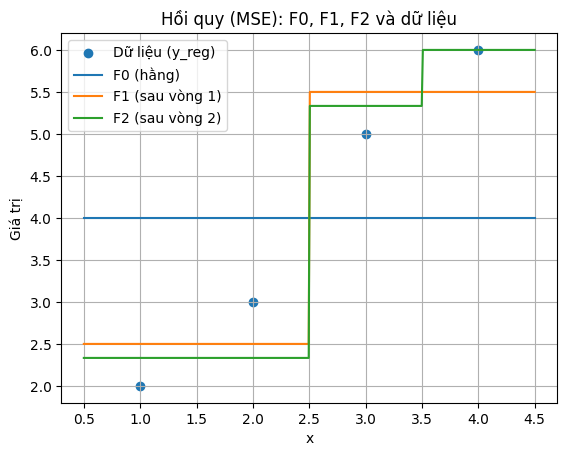

In [ ]:
xgrid = np.linspace(0.5, 4.5, 400)

def F1_reg_on_grid(x):
    return reg['F0'] + (reg['g1L'] if x < reg['t1'] else reg['g1R'])

def F2_reg_on_grid(x):
    val1 = F1_reg_on_grid(x)
    add  = (reg['g2L'] if x < reg['t2'] else reg['g2R'])
    return val1 + add

y_F0 = np.full_like(xgrid, reg['F0'])
y_F1 = np.array([F1_reg_on_grid(x) for x in xgrid])
y_F2 = np.array([F2_reg_on_grid(x) for x in xgrid])

plt.figure()
plt.scatter(xs, y_reg, label="Dữ liệu (y_reg)")
plt.plot(xgrid, y_F0, label="F0 (hằng)")
plt.plot(xgrid, y_F1, label="F1 (sau vòng 1)")
plt.plot(xgrid, y_F2, label="F2 (sau vòng 2)")
plt.title("Hồi quy (MSE): F0, F1, F2 và dữ liệu")
plt.xlabel("x")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)
plt.show()

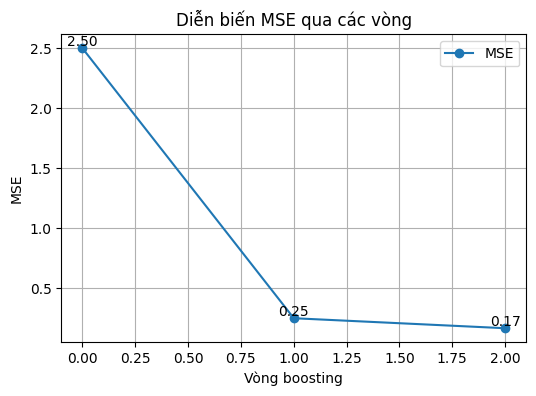

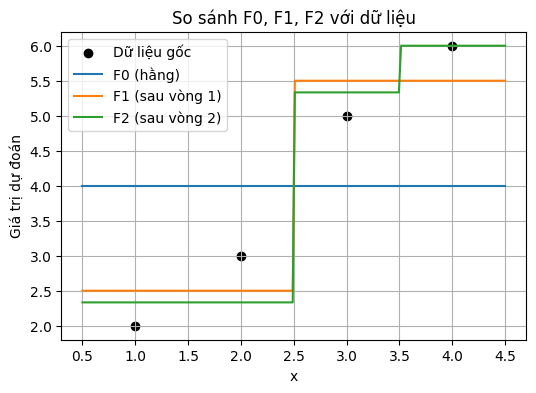

,x,y thực,F1,Residual_1,F2,Residual_2
0,1.0,2.0,2.5,-0.5,2.333333,-0.333333
1,2.0,3.0,2.5,0.5,2.333333,0.666667
2,3.0,5.0,5.5,-0.5,5.333333,-0.333333
3,4.0,6.0,5.5,0.5,6.000000,0.000000


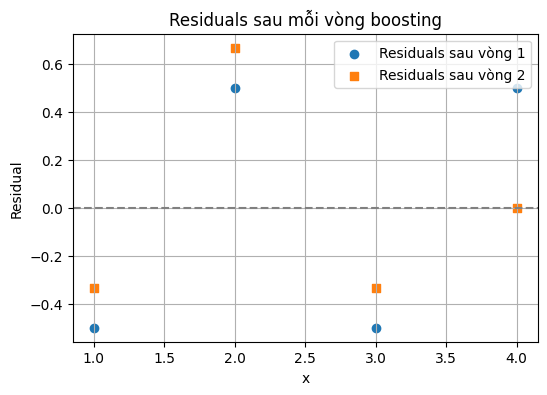

In [ ]:
def visualize_regression(xs, y_reg, reg):
    # 1. Loss qua từng vòng
    rounds = [0, 1, 2]
    losses = [
        ((y_reg - reg['F0'])**2).mean(),
        reg['mse1'],
        reg['mse2']
    ]
    plt.figure(figsize=(6,4))
    plt.plot(rounds, losses, marker='o', label="MSE")
    for i, v in enumerate(losses):
        plt.text(rounds[i], v+0.02, f"{v:.2f}", ha="center")
    plt.xlabel("Vòng boosting")
    plt.ylabel("MSE")
    plt.title("Diễn biến MSE qua các vòng")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 2. Đường dự đoán F0, F1, F2
    xgrid = np.linspace(0.5, 4.5, 200)

    def F1_reg_on_grid(x):
        return reg['F0'] + (reg['g1L'] if x < reg['t1'] else reg['g1R'])

    def F2_reg_on_grid(x):
        val1 = F1_reg_on_grid(x)
        add  = (reg['g2L'] if x < reg['t2'] else reg['g2R'])
        return val1 + add

    y_F0 = np.full_like(xgrid, reg['F0'])
    y_F1 = np.array([F1_reg_on_grid(x) for x in xgrid])
    y_F2 = np.array([F2_reg_on_grid(x) for x in xgrid])

    plt.figure(figsize=(6,4))
    plt.scatter(xs, y_reg, color="black", label="Dữ liệu gốc")
    plt.plot(xgrid, y_F0, label="F0 (hằng)")
    plt.plot(xgrid, y_F1, label="F1 (sau vòng 1)")
    plt.plot(xgrid, y_F2, label="F2 (sau vòng 2)")
    plt.xlabel("x")
    plt.ylabel("Giá trị dự đoán")
    plt.title("So sánh F0, F1, F2 với dữ liệu")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Residuals sau từng vòng
    r1 = y_reg - reg['F1']
    r2 = y_reg - reg['F2']

    df = pd.DataFrame({
        "x": xs,
        "y thực": y_reg,
        "F1": reg['F1'],
        "Residual_1": r1,
        "F2": reg['F2'],
        "Residual_2": r2
    })
    display(df)

    plt.figure(figsize=(6,4))
    plt.scatter(xs, r1, marker="o", label="Residuals sau vòng 1")
    plt.scatter(xs, r2, marker="s", label="Residuals sau vòng 2")
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("x")
    plt.ylabel("Residual")
    plt.title("Residuals sau mỗi vòng boosting")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualization
visualize_regression(xs, y_reg, reg)

## 5. Decision Stumps

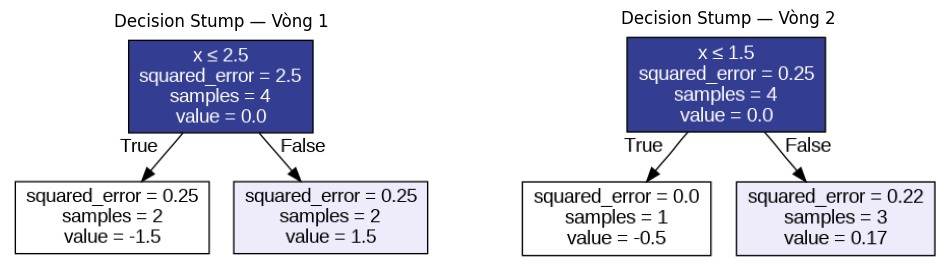

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import re
import matplotlib.pyplot as plt
from PIL import Image

def export_tree_custom_colors_keep_labels(stump, feature_names, filename="tree_custom"):
    dot_data = export_graphviz(
        stump,
        out_file=None,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        special_characters=True,
        precision=2
    )

    dot_data = re.sub(r'(0 \[label=.*?), fillcolor=.*?\]',
                      r'\1, style=filled, fillcolor="#333D91", fontcolor="white"]',
                      dot_data)

    dot_data = re.sub(r'(1 \[label=.*?), fillcolor=.*?\]',
                      r'\1, style=filled, fillcolor="#FFFFFF", fontcolor="black"]',
                      dot_data)

    dot_data = re.sub(r'(2 \[label=.*?), fillcolor=.*?\]',
                      r'\1, style=filled, fillcolor="#EEECFA", fontcolor="black"]',
                      dot_data)

    graph = graphviz.Source(dot_data)
    graph.render(filename, format="png", cleanup=False)
    return filename + ".png"

# export files
file1 = export_tree_custom_colors_keep_labels(stump1, ["x"], filename="stump1_custom")
file2 = export_tree_custom_colors_keep_labels(stump2, ["x"], filename="stump2_custom")

# Hiển thị song song
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, f, title in zip(axes, [file1, file2], ["Decision Stump — Vòng 1", "Decision Stump — Vòng 2"]):
    img = Image.open(f)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)
plt.show()